In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')
import missingno
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.metrics import accuracy_score

from matplotlib import font_manager, rc
font_path = "/content/drive/MyDrive/L1/Notebooks/dataset/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

- cloth, hobby share 증감 독립변수

In [48]:
# cloth, hobby 세부 카테고리 증감률 계산을 포함한 df read
df = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/X_cloth_hobby_var.pkl')
df.head()

,CUSTNO,spent_less,cloth_men_purch_diff,cloth_kids_purch_diff,cloth_casual_purch_diff,cloth_lingerie_purch_diff,cloth_sports_purch_diff,cloth_etc_purch_diff,cloth_business_purch_diff,hobby_media_purch_diff,hobby_child_purch_diff,hobby_pet_purch_diff,hobby_outdoor_purch_diff,hobby_sports_purch_diff,hobby_health_purch_diff,hobby_instex_purch_diff,cloth_women_purch_diff,hobby_golf_purch_diff
0,00001,1,-0.000900,0.0,0.000137,0.000000,0.0,-0.000051,-0.000102,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000
1,00002,0,0.000000,0.0,0.000091,0.001979,0.0,-0.000142,0.000000,0.0,0.0,-0.00036,0.0,0.0,0.0,0.0,0.0,-0.000468
2,00004,1,-0.000028,0.0,-0.000032,0.000000,0.0,0.000000,0.000253,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,-0.000075
3,00006,0,0.000071,0.0,0.000038,0.000350,0.0,0.000037,-0.000011,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000012
4,00007,0,-0.000100,0.0,0.000683,0.000114,0.0,-0.000813,-0.000187,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,-0.000003


In [49]:
df.cloth_men_purch_diff.value_counts()

 0.000000    12792
-0.000100      410
-0.000200      237
-0.000300      161
-0.000400      119
             ...  
-0.000109        1
-0.000078        1
 0.000320        1
 0.000272        1
-0.000145        1
Name: cloth_men_purch_diff, Length: 1937, dtype: int64

In [50]:
ddf = df.copy()

In [51]:
afill_diff = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/X_Afill_var.pkl')
ddf = pd.merge(ddf, afill_diff, on='CUSTNO', how='right').fillna(0)

- Recency 독립변수

In [52]:
Recency = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/X_recency.pkl')
ddf = pd.merge(ddf, Recency, on='CUSTNO', how='right').fillna(0)

- membership 독립변수

In [53]:
membership = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/membership.pkl')
ddf = pd.merge(ddf, 
                 membership[['CUSTNO','MEMBERSHIP_CAT']], 
                    on='CUSTNO', how='left').fillna(0)

- Value_categorize 독립변수
    - 고,중,저가 제품 구매빈도 변동

In [54]:
value_cat2 = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/categorize_value_abs.pkl')
ddf = pd.merge(ddf, 
                 value_cat2, on='CUSTNO', how='left').fillna(0)

- visit_per_day
    - 일 방문횟수 변동

In [55]:
visit_per_day = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/PERDAY_VISITING.pkl')
visit_per_day
ddf = pd.merge(ddf, visit_per_day, on='CUSTNO', how='left').fillna(0)

- 고객속성 군집분석 독립변수
    - 성별, 연령대, 지역, 구매금액으로 나눈 고객그룹

In [56]:
# cust_class = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/cluster_label.pkl')
ddf.CUSTNO = ddf.CUSTNO.astype(int)
# ddf = pd.merge(ddf, 
#                  cust_class, on='CUSTNO', how='left').fillna(0)

In [57]:
ddf.head()

,CUSTNO,spent_less,cloth_men_purch_diff,cloth_kids_purch_diff,cloth_casual_purch_diff,cloth_lingerie_purch_diff,cloth_sports_purch_diff,cloth_etc_purch_diff,cloth_business_purch_diff,hobby_media_purch_diff,hobby_child_purch_diff,hobby_pet_purch_diff,hobby_outdoor_purch_diff,hobby_sports_purch_diff,hobby_health_purch_diff,hobby_instex_purch_diff,cloth_women_purch_diff,hobby_golf_purch_diff,A_purch_diff,B_purch_diff,Recency,MEMBERSHIP_CAT,cloth_highvalue,cloth_lowvalue,cloth_mediumvalue,hobby_highvalue,hobby_lowvalue,hobby_mediumvalue,CLOTH_MEN_PERDAY_VISITING,CLOTH_CASUAL_PERDAY_VISITING,CLOTH_ETC_PERDAY_VISITING,CLOTH_BUSINESS_PERDAY_VISITING,CLOTH_LINGERIE_PERDAY_VISITING,CLOTH_SPORTS_PERDAY_VISITING,CLOTH_KIDS_PERDAY_VISITING,CLOTH_WOMEN_PERDAY_VISITING,HOBBY_PET_PERDAY_VISITING,HOBBY_GOLF_PERDAY_VISITING,HOBBY_MEDIA_PERDAY_VISITING,HOBBY_CHILD_PERDAY_VISITING,HOBBY_HEALTH_PERDAY_VISITING,HOBBY_OUTDOOR_PERDAY_VISITING,HOBBY_SPORTS_PERDAY_VISITING,HOBBY_INSTEX_PERDAY_VISITING
0,1,1,-0.000900,0.0,0.000137,0.000000,0.0,-0.000051,-0.000102,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000050,0.000000,29,0,3.0,0.0,0.0,0.0,0.0,0.0,-0.0659,0.1099,-0.0110,0.000,0.0000,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0.000000,0.0,0.000091,0.001979,0.0,-0.000142,0.000000,0.0,0.0,-0.00036,0.0,0.0,0.0,0.0,0.0,-0.000468,0.000032,0.000000,2,0,2.0,0.0,0.0,5.0,2.0,0.0,0.0000,0.0330,-0.0330,0.000,0.0219,0.0,0.0,0.0,-0.011,-0.0549,0.0,0.0,0.0,0.0,0.0,0.0
2,4,1,-0.000028,0.0,-0.000032,0.000000,0.0,0.000000,0.000253,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,-0.000075,0.000025,0.000046,9,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0000,-0.0439,0.0000,0.033,0.0000,0.0,0.0,0.0,0.000,-0.0110,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0,0.000071,0.0,0.000038,0.000350,0.0,0.000037,-0.000011,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000012,0.000058,0.000050,25,0,12.0,0.0,4.0,1.0,0.0,0.0,0.0110,0.0879,0.0219,-0.011,0.0659,0.0,0.0,0.0,0.000,0.0110,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0,-0.000100,0.0,0.000683,0.000114,0.0,-0.000813,-0.000187,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,-0.000003,0.000233,0.000000,2,0,5.0,0.0,0.0,1.0,0.0,0.0,-0.0110,0.0440,-0.0769,-0.022,0.0110,0.0,0.0,0.0,0.000,-0.0110,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
ddf.columns

Index(['CUSTNO', 'spent_less', 'cloth_men_purch_diff', 'cloth_kids_purch_diff',
       'cloth_casual_purch_diff', 'cloth_lingerie_purch_diff',
       'cloth_sports_purch_diff', 'cloth_etc_purch_diff',
       'cloth_business_purch_diff', 'hobby_media_purch_diff',
       'hobby_child_purch_diff', 'hobby_pet_purch_diff',
       'hobby_outdoor_purch_diff', 'hobby_sports_purch_diff',
       'hobby_health_purch_diff', 'hobby_instex_purch_diff',
       'cloth_women_purch_diff', 'hobby_golf_purch_diff', 'A_purch_diff',
       'B_purch_diff', 'Recency', 'MEMBERSHIP_CAT', 'cloth_highvalue',
       'cloth_lowvalue', 'cloth_mediumvalue', 'hobby_highvalue',
       'hobby_lowvalue', 'hobby_mediumvalue', 'CLOTH_MEN_PERDAY_VISITING',
       'CLOTH_CASUAL_PERDAY_VISITING', 'CLOTH_ETC_PERDAY_VISITING',
       'CLOTH_BUSINESS_PERDAY_VISITING', 'CLOTH_LINGERIE_PERDAY_VISITING',
       'CLOTH_SPORTS_PERDAY_VISITING', 'CLOTH_KIDS_PERDAY_VISITING',
       'CLOTH_WOMEN_PERDAY_VISITING', 'HOBBY_PET_PERDAY_VISI

In [59]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16295 entries, 0 to 16294
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CUSTNO                          16295 non-null  int64  
 1   spent_less                      16295 non-null  int64  
 2   cloth_men_purch_diff            16295 non-null  float64
 3   cloth_kids_purch_diff           16295 non-null  float64
 4   cloth_casual_purch_diff         16295 non-null  float64
 5   cloth_lingerie_purch_diff       16295 non-null  float64
 6   cloth_sports_purch_diff         16295 non-null  float64
 7   cloth_etc_purch_diff            16295 non-null  float64
 8   cloth_business_purch_diff       16295 non-null  float64
 9   hobby_media_purch_diff          16295 non-null  float64
 10  hobby_child_purch_diff          16295 non-null  float64
 11  hobby_pet_purch_diff            16295 non-null  float64
 12  hobby_outdoor_purch_diff        

In [60]:
print('get_dummies() 수행 전 데이터 Shape:', ddf.shape)
ddf = pd.get_dummies(ddf)
print('get_dummies() 수행 후 데이터 Shape:', ddf.shape)

get_dummies() 수행 전 데이터 Shape: (16295, 44)
get_dummies() 수행 후 데이터 Shape: (16295, 47)


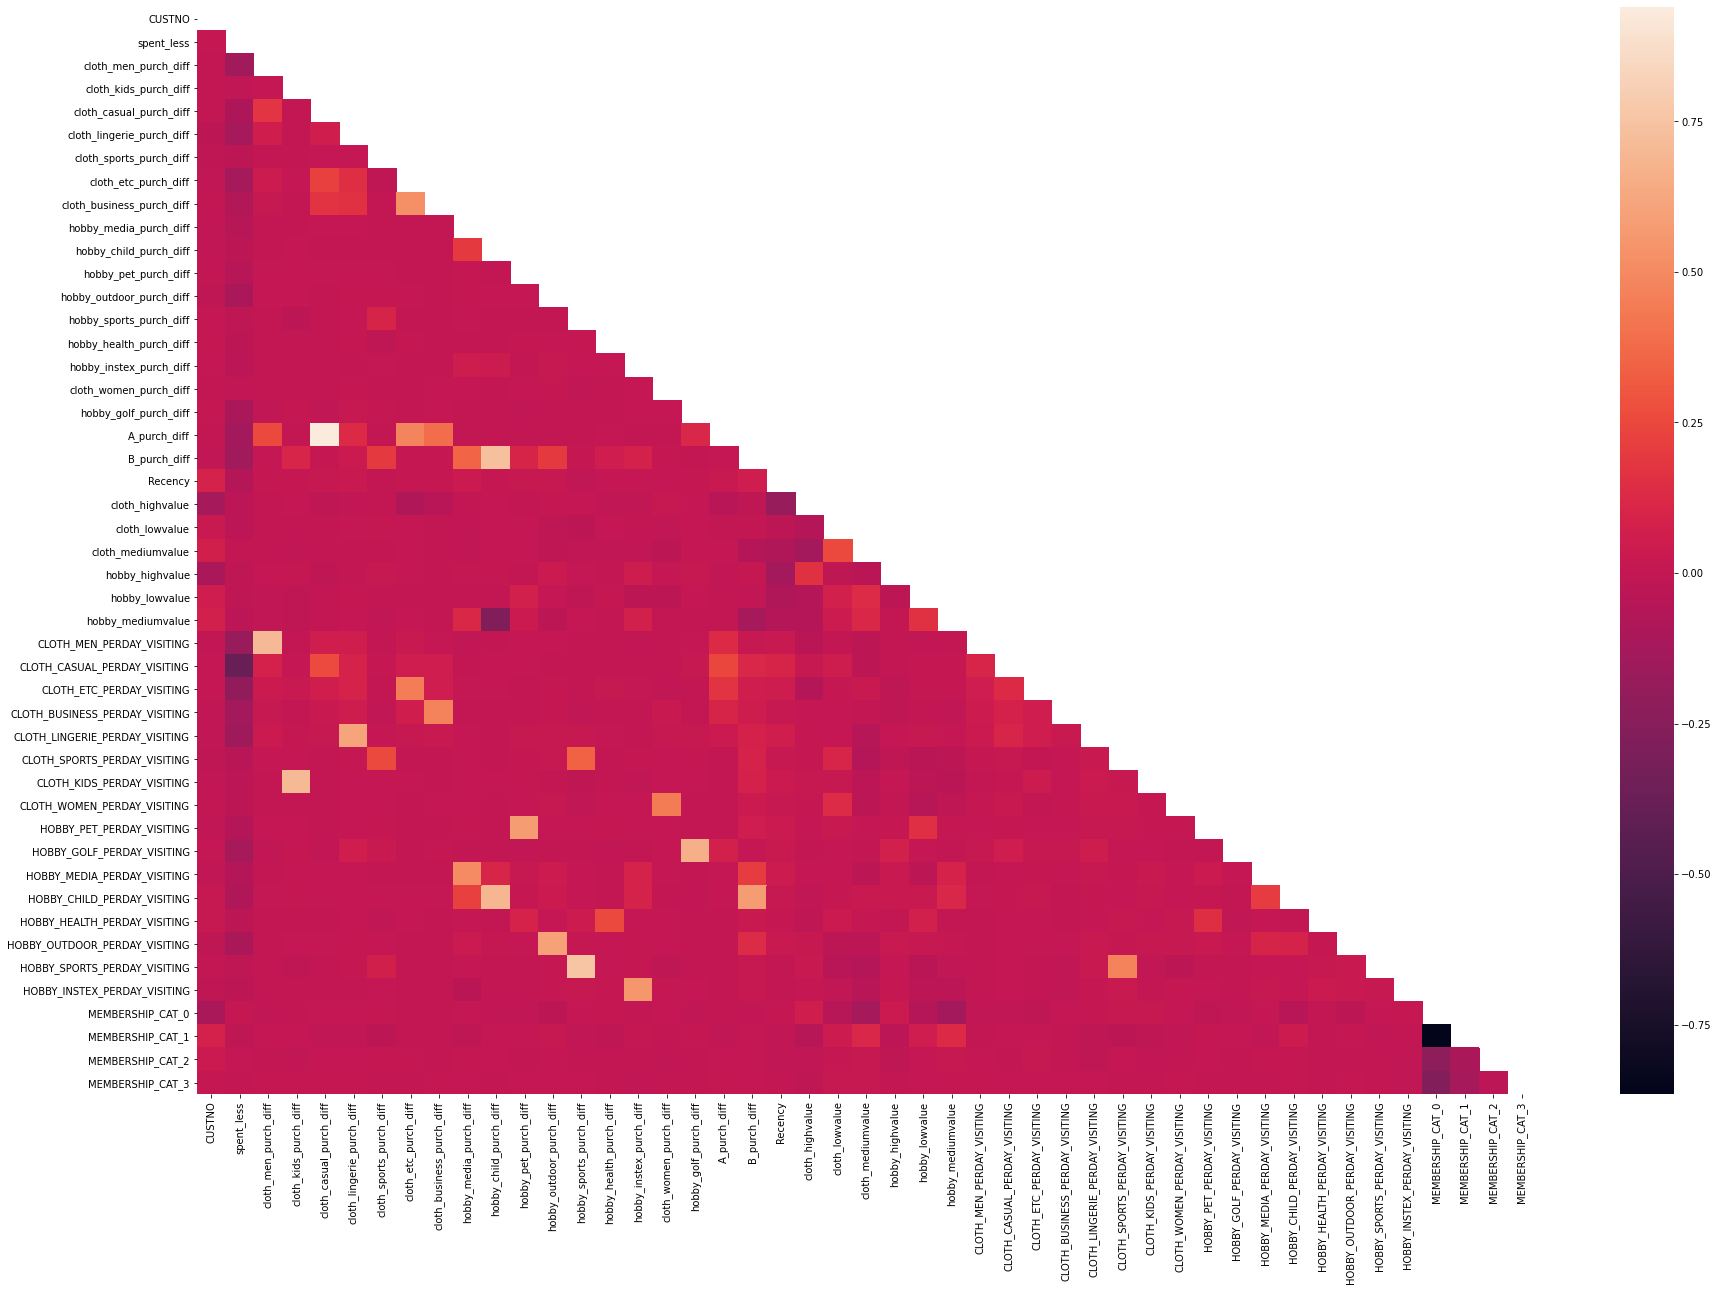

In [61]:
corr = ddf.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
plt.figure(figsize=(30,20))
sns.heatmap(corr, mask=mask, annot=False)

In [62]:
ad = ddf.corr()
ad.style.background_gradient(cmap = 'coolwarm')

,CUSTNO,spent_less,cloth_men_purch_diff,cloth_kids_purch_diff,cloth_casual_purch_diff,cloth_lingerie_purch_diff,cloth_sports_purch_diff,cloth_etc_purch_diff,cloth_business_purch_diff,hobby_media_purch_diff,hobby_child_purch_diff,hobby_pet_purch_diff,hobby_outdoor_purch_diff,hobby_sports_purch_diff,hobby_health_purch_diff,hobby_instex_purch_diff,cloth_women_purch_diff,hobby_golf_purch_diff,A_purch_diff,B_purch_diff,Recency,cloth_highvalue,cloth_lowvalue,cloth_mediumvalue,hobby_highvalue,hobby_lowvalue,hobby_mediumvalue,CLOTH_MEN_PERDAY_VISITING,CLOTH_CASUAL_PERDAY_VISITING,CLOTH_ETC_PERDAY_VISITING,CLOTH_BUSINESS_PERDAY_VISITING,CLOTH_LINGERIE_PERDAY_VISITING,CLOTH_SPORTS_PERDAY_VISITING,CLOTH_KIDS_PERDAY_VISITING,CLOTH_WOMEN_PERDAY_VISITING,HOBBY_PET_PERDAY_VISITING,HOBBY_GOLF_PERDAY_VISITING,HOBBY_MEDIA_PERDAY_VISITING,HOBBY_CHILD_PERDAY_VISITING,HOBBY_HEALTH_PERDAY_VISITING,HOBBY_OUTDOOR_PERDAY_VISITING,HOBBY_SPORTS_PERDAY_VISITING,HOBBY_INSTEX_PERDAY_VISITING,MEMBERSHIP_CAT_0,MEMBERSHIP_CAT_1,MEMBERSHIP_CAT_2,MEMBERSHIP_CAT_3
CUSTNO,1.000000,0.010119,-0.003139,-0.001056,-0.003753,-0.019261,-0.014056,-0.011433,-0.003428,-0.007664,-0.010322,-0.002263,-0.019127,0.007200,0.014904,0.002378,-0.001530,0.010582,-0.004333,-0.009102,0.087116,-0.121488,0.023969,0.067598,-0.107484,0.055367,0.079475,-0.006749,0.004950,0.008156,-0.006882,-0.011440,-0.017992,-0.007319,-0.002820,-0.006542,0.008622,-0.011126,0.019116,0.016226,-0.012585,-0.002022,-0.012911,-0.098502,0.086517,0.033113,0.014297
spent_less,0.010119,1.000000,-0.145593,-0.009490,-0.090531,-0.118448,-0.020200,-0.120865,-0.071325,-0.049208,-0.025919,-0.049500,-0.106217,-0.016420,-0.024627,-0.029248,-0.009004,-0.104330,-0.137087,-0.143691,-0.066755,-0.026408,-0.028990,0.000996,-0.016184,-0.018358,-0.033030,-0.178165,-0.382372,-0.206001,-0.133157,-0.146249,-0.045051,-0.031684,-0.021995,-0.055930,-0.119811,-0.066181,-0.087517,-0.026114,-0.100306,-0.018855,-0.024720,0.015230,-0.015001,0.002962,-0.005028
cloth_men_purch_diff,-0.003139,-0.145593,1.000000,0.002043,0.176406,0.063743,0.001282,0.038171,0.022522,-0.001722,0.000776,0.002812,0.003227,-0.000474,0.000057,-0.003282,-0.003347,-0.009781,0.249022,0.006502,0.014219,-0.002355,0.001435,-0.002185,0.002018,-0.007648,-0.005858,0.702016,0.085429,0.036560,0.020394,0.036938,0.006488,-0.002737,0.001639,0.004768,-0.008081,0.000402,0.003836,-0.003130,0.000689,0.000970,0.000129,-0.006626,0.003001,-0.000629,0.010060
cloth_kids_purch_diff,-0.001056,-0.009490,0.002043,1.000000,-0.001465,-0.000793,-0.000412,0.002210,-0.001530,-0.002739,0.002365,0.006908,0.002861,-0.022837,-0.002176,-0.003650,-0.003565,0.016082,0.001020,0.100999,0.015029,0.006834,-0.002820,-0.011935,0.010135,-0.016265,-0.013619,-0.001067,0.007314,0.029007,0.000898,0.013340,0.002055,0.704874,-0.000215,0.008491,0.015947,0.003228,0.011783,-0.002021,0.004625,-0.016814,-0.001797,-0.004921,0.003212,-0.005897,0.009622
cloth_casual_purch_diff,-0.003753,-0.090531,0.176406,-0.001465,1.000000,0.062486,0.002090,0.214846,0.168260,0.002066,-0.000150,0.002935,0.000088,0.000388,0.000899,0.001116,-0.002043,-0.010746,0.940229,0.010865,0.020087,-0.014459,-0.001220,0.000545,-0.012966,-0.002346,0.001361,0.064112,0.257308,0.061599,0.027292,0.017944,0.000320,-0.000189,-0.000844,0.000540,-0.006132,0.008032,0.004609,0.000500,0.002368,0.000445,0.000748,0.004490,-0.011255,0.002989,0.013083
cloth_lingerie_purch_diff,-0.019261,-0.118448,0.063743,-0.000793,0.062486,1.000000,0.008894,0.149410,0.158934,0.003305,0.000857,0.003713,0.015813,0.005301,0.009835,-0.004684,0.014922,0.020222,0.128578,0.036490,0.024812,-0.007400,0.008745,-0.003882,-0.004507,0.011984,0.005961,0.064518,0.087342,0.089253,0.046276,0.608759,0.011090,0.004230,0.008545,0.004666,0.059931,0.002337,0.006738,0.002167,0.011278,0.009722,-0.002231,0.004627,-0.010294,0.002301,0.011012
cloth_sports_purch_diff,-0.014056,-0.020200,0.001282,-0.000412,0.002090,0.008894,1.000000,-0.013521,-0.004716,0.001349,0.000456,0.004546,0.009461,0.098450,-0.014209,0.002765,0

- 독립변수끼리 상관관계가 높은 columns 제거 (상관관계 0.7이상 1미만)

In [63]:
ddf.drop(['cloth_casual_purch_diff',
          'hobby_child_purch_diff',
          'MEMBERSHIP_CAT_0',
          'MEMBERSHIP_CAT_1',
          'HOBBY_SPORTS_PERDAY_VISITING',
          'CLOTH_KIDS_PERDAY_VISITING',
          'cloth_men_purch_diff',
          'cloth_kids_purch_diff',
          'HOBBY_SPORTS_PERDAY_VISITING'],axis=1,inplace=True)

In [64]:
ddf.to_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/ddf_with_CUSTNO.pkl')

In [65]:
ddf.drop(['CUSTNO'], axis=1, inplace=True)

In [66]:
ddf.to_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/dataset_for_analysis.pkl')